In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns             
from sklearn.dummy import DummyRegressor
FILE_PATH = "marks_dataset.xlsx"


In [14]:
# Read all sheets and merge them into a single dataframe
xls = pd.ExcelFile(FILE_PATH)
frames = []
for sheet in xls.sheet_names:
    df_sheet = pd.read_excel(FILE_PATH, sheet_name=sheet)
    df_sheet['sheet_id'] = sheet       
    frames.append(df_sheet)
raw = pd.concat(frames, ignore_index=True)
print("Raw merged shape:", raw.shape)


Raw merged shape: (272, 32)


In [3]:
# 2A: Standardize column names (strip whitespace)
raw.columns = [str(c).strip() for c in raw.columns]

# 2B: Define expected columns 
expected_cols = [
    # assignments
    "As:1","As:2","As:3","As:4",
    # quizzes
    "Qz:1","Qz:2","Qz:3","Qz:4","Qz:5","Qz:6",
    # totals (only totals, NOT subparts)
    "S-I","S-II","Final"
]

# Keep only columns that exist in the data (some sheets may not have all)
keep_cols = [c for c in expected_cols if c in raw.columns]
print("Columns kept:", keep_cols)

# Also keep sheet_id for traceability (optional)
if 'sheet_id' in raw.columns:
    keep_cols_with_meta = keep_cols + ['sheet_id']
else:
    keep_cols_with_meta = keep_cols

df = raw[keep_cols_with_meta].copy()

# 2C: Drop duplicate rows (exact duplicates)
df.drop_duplicates(inplace=True)

# 2D: Coerce kept columns to numeric (non-numeric -> NaN) then fill missing with 0 
for col in keep_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 2E: If there are rows with all zeros across features and targets, drop them (likely empty rows)
feature_zero_mask = (df[keep_cols].sum(axis=1) == 0)
num_all_zero_rows = feature_zero_mask.sum()
print("Rows with all-zero kept-columns:", num_all_zero_rows)
# Drop rows that have all kept columns zero (they contain no information)
df = df[~feature_zero_mask].reset_index(drop=True)

print("Cleaned df shape:", df.shape)


Columns kept: ['As:1', 'As:2', 'As:3', 'As:4', 'Qz:1', 'Qz:2', 'Qz:3', 'Qz:4', 'Qz:5', 'Qz:6', 'S-I', 'S-II', 'Final']
Rows with all-zero kept-columns: 6
Cleaned df shape: (266, 14)


,count,mean,std,min,25%,50%,75%,max
As:1,266.0,55.679135,31.544475,0.0,34.1250,60.500,72.500,130.0
As:2,266.0,59.014286,34.082084,0.0,42.3750,67.000,83.875,120.0
As:3,266.0,67.904887,30.890412,0.0,52.0000,75.000,88.000,120.0
As:4,266.0,39.610150,23.593114,0.0,24.0000,45.000,57.000,80.0
Qz:1,266.0,3.948571,2.865045,0.0,1.5000,3.500,6.000,10.0
Qz:2,266.0,3.989925,3.334454,0.0,1.0000,3.750,6.000,15.0
Qz:3,266.0,4.582030,3.232261,0.0,2.0000,4.000,7.000,16.0
Qz:4,266.0,4.060827,3.376814,0.0,1.0000,3.500,6.500,10.0
Qz:5,266.0,3.796316,3.154312,0.0,1.0000,3.000,6.375,10.0
Qz:6,266.0,3.833910,2.993303,0.0,1.0000,4.000,6.000,10.0


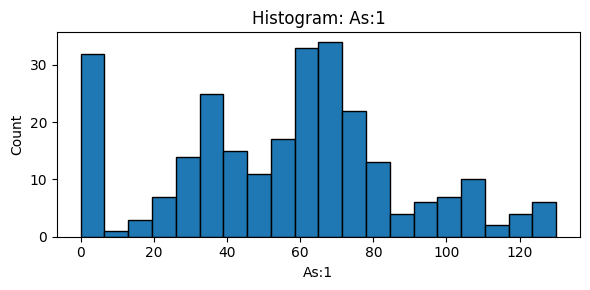

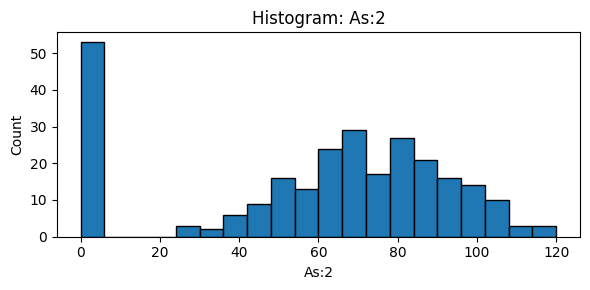

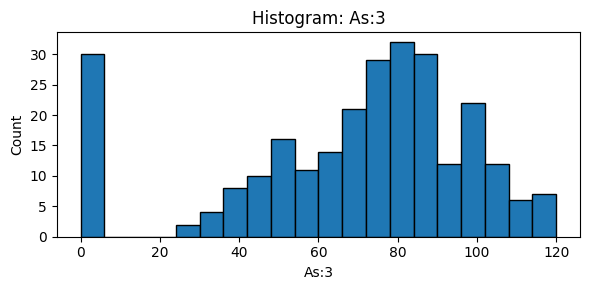

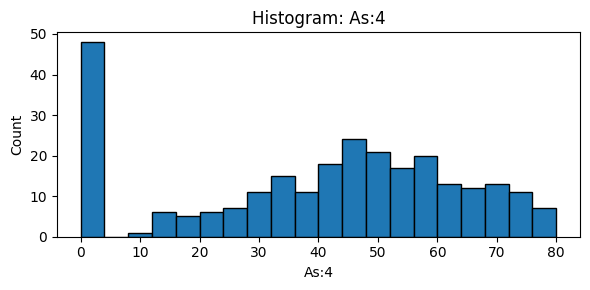

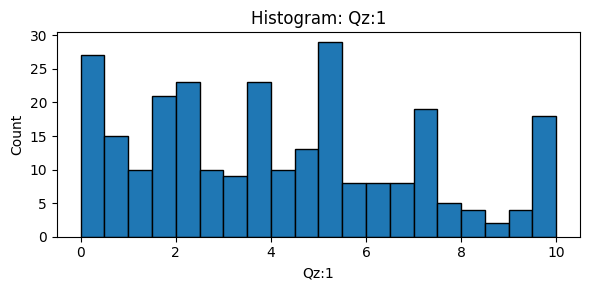

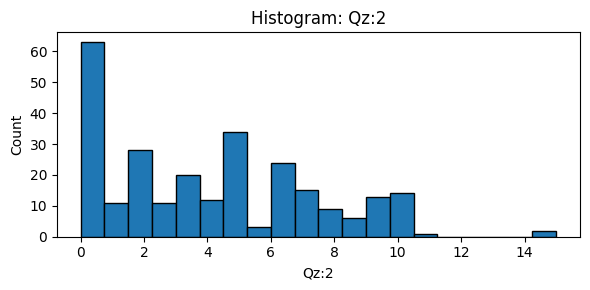

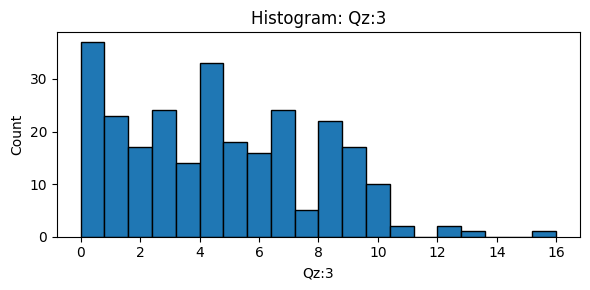

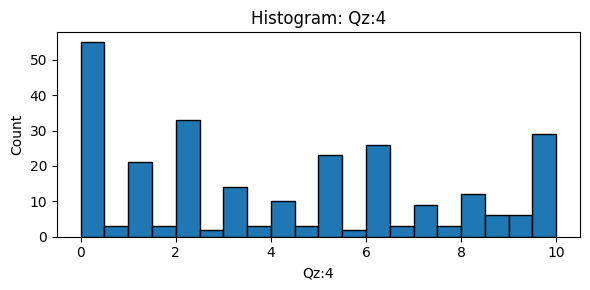

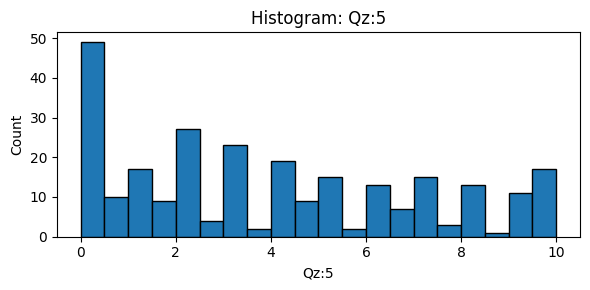

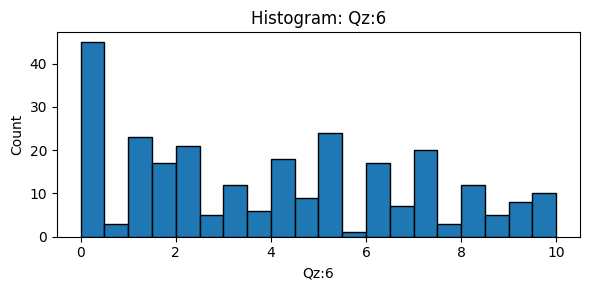

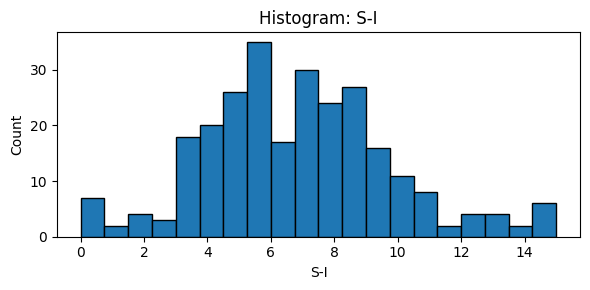

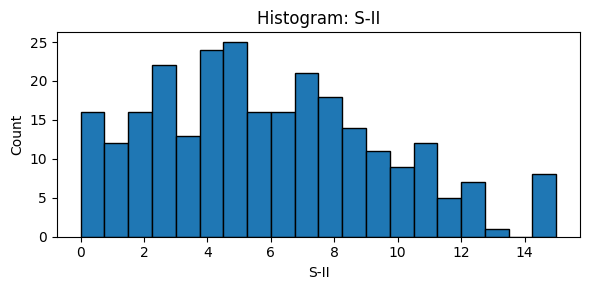

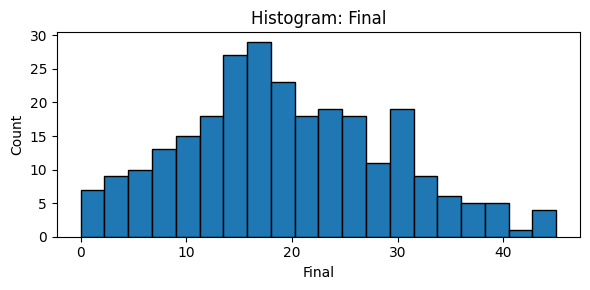

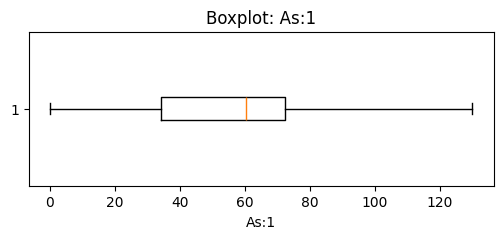

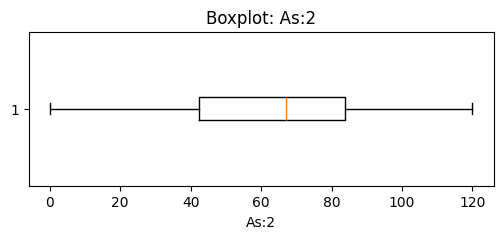

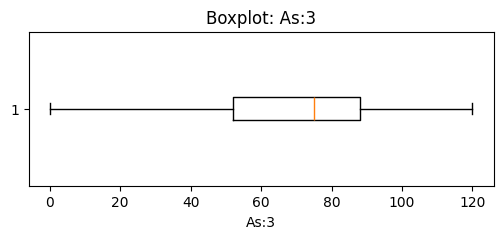

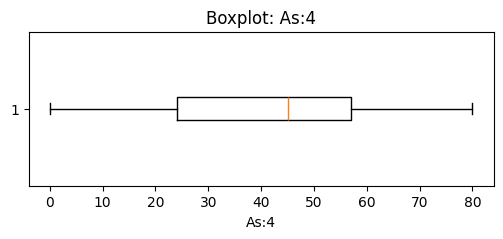

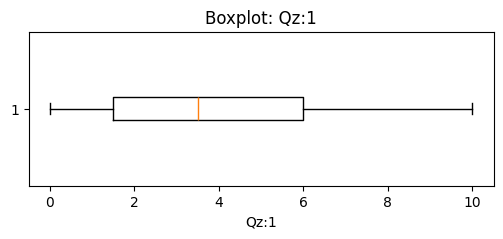

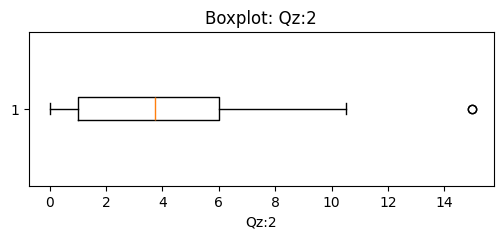

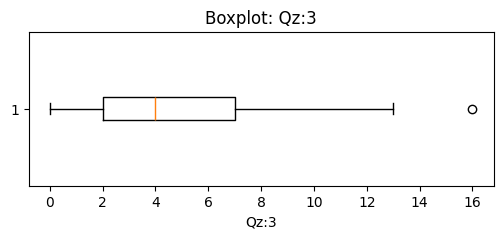

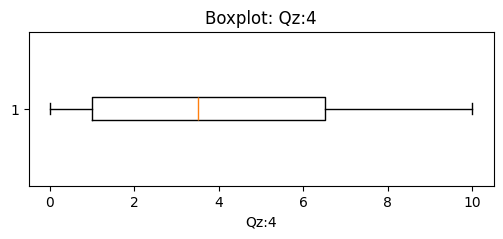

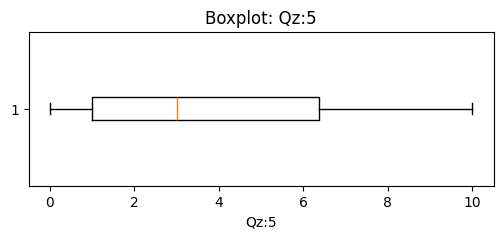

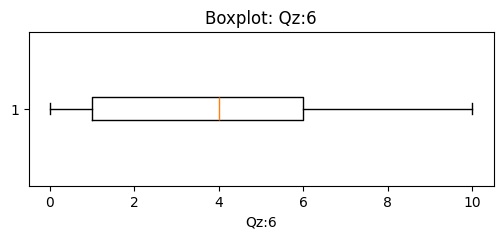

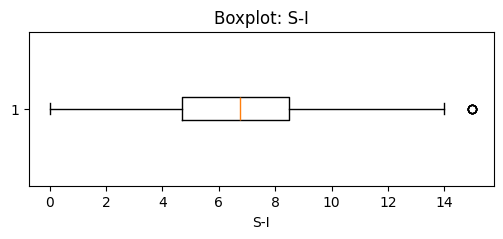

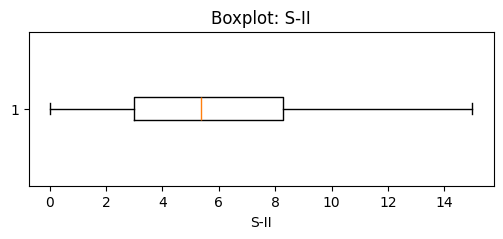

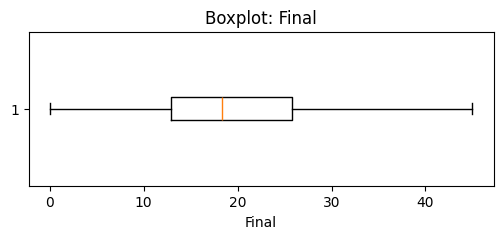

In [5]:
# 3A: Descriptive statistics
display(df[keep_cols].describe().T)

# 3B: Histograms for each kept numeric column
for col in keep_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col], bins=20, edgecolor='k')
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 3C: Boxplots to inspect spread and outliers
for col in keep_cols:
    plt.figure(figsize=(6,2))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)
    plt.show()


,As:1,As:2,As:3,As:4,Qz:1,Qz:2,Qz:3,Qz:4,Qz:5,Qz:6,S-I,S-II,Final
As:1,1.000000,0.089873,0.248114,0.194182,0.190018,0.409677,0.147755,0.206948,0.141163,0.070014,-0.023937,-0.050606,-0.036169
As:2,0.089873,1.000000,0.299250,0.254986,0.251622,0.095151,0.321286,0.221347,0.241311,0.203634,-0.031168,0.136300,0.088945
As:3,0.248114,0.299250,1.000000,0.278830,0.324598,0.242935,0.287587,0.324863,0.378650,0.300852,0.047340,0.101979,0.009222
As:4,0.194182,0.254986,0.278830,1.000000,0.123019,0.012437,0.201890,0.161546,0.145780,0.203770,0.006102,0.204482,0.294482
Qz:1,0.190018,0.251622,0.324598,0.123019,1.000000,0.214017,0.278891,0.251567,0.317518,0.276631,0.221115,0.203543,0.096176
Qz:2,0.409677,0.095151,0.242935,0.012437,0.214017,1.000000,0.163775,0.378763,0.302953,0.185827,0.123641,0.027072,-0.071850
Qz:3,0.147755,0.321286,0.287587,0.201890,0.278891,0.163775,1.000000,0.315175,0.414992,0.364449,0.067242,0.155852,-0.000750
Qz:4,0.206948,0.221347,0.324863,0.161546,0.251567,0.378763,0.315175,1.000000,0.394826,0.266867,0.152038,0.263473,0.123179
Qz:5,0.141163,0.241311,0.378650,0.145780,0.317518,0.302953,0.414992,0.394826,1.000000,0.414436,0.109049,0.204415,0.100200
Qz:6,0.070014,0.203634,0.300852,0.203770,0.276631,0.185827,0.364449,0.266867,0.414436,1.000000,0.168712,0.238261,0.162747


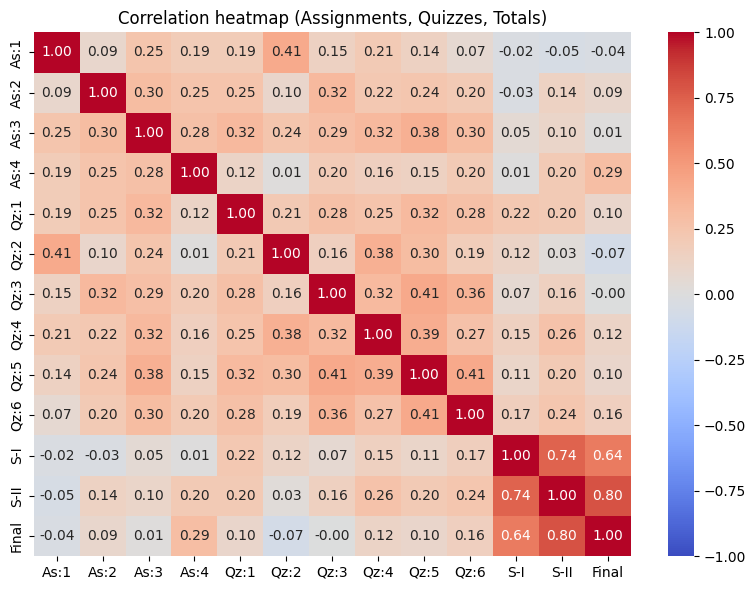

In [6]:
# 4A: Correlation matrix (Pearson) among kept columns
corr = df[keep_cols].corr()

# 4B: Show numeric correlation table
display(corr)

# 4C: Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap (Assignments, Quizzes, Totals)")
plt.tight_layout()
plt.show()


In [7]:
# Simple split function
def split_manual(df_local, target_col, test_frac=0.2, random_state=1):
    """Shuffle df and split into train/test, returning train_df, test_df."""
    df_shuffled = df_local.sample(frac=1, random_state=random_state).reset_index(drop=True)
    n_test = int(len(df_shuffled) * test_frac)
    test_df = df_shuffled.iloc[:n_test].reset_index(drop=True)
    train_df = df_shuffled.iloc[n_test:].reset_index(drop=True)
    return train_df, test_df

# Bias column adder
def add_bias(X):
    """Add a column of ones as first column for intercept."""
    return np.hstack([np.ones((X.shape[0],1)), X])

# Fit OLS via normal equation
def fit_ols(X, y):
    """X must include bias column. Return beta coefficients."""
    XtX = X.T @ X
    ridge = 1e-8 * np.eye(XtX.shape[0])   # tiny regularization for stability
    beta = np.linalg.inv(XtX + ridge) @ (X.T @ y)
    return beta

# Predict
def predict_ols(X, beta):
    return X @ beta

# Metrics
def mae(y_true, y_pred): return float(np.mean(np.abs(y_true - y_pred)))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1 - ss_res/ss_tot) if ss_tot != 0 else 0.0

# Bootstrap MAE (train only)
def bootstrap_mae_train(X_train, y_train, n_boot=500, random_state=42):
    """Return mean MAE and 95% CI computed by bootstrap resampling on training data."""
    np.random.seed(random_state)
    n = X_train.shape[0]
    maes = []
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        Xb = X_train[idx]
        yb = y_train[idx]
        beta_b = fit_ols(Xb, yb)
        preds_b = predict_ols(Xb, beta_b)
        maes.append(mae(yb, preds_b))
    maes = np.array(maes)
    return maes.mean(), (np.percentile(maes,2.5), np.percentile(maes,97.5))


In [15]:
# RQ1: Predict S-I
target = "S-I"
predictor_candidates = [c for c in keep_cols if c.startswith("As:") or c.startswith("Qz:")]  # As & Qz
print("RQ1 predictors considered:", predictor_candidates)

# Prepare dataset (drop rows missing target -> target was filled with 0 earlier; keep anyway)
df_rq1 = df[predictor_candidates + [target]].copy()

# Split
train1, test1 = split_manual(df_rq1, target_col=target, test_frac=0.2, random_state=11)

# Convert to numpy arrays
Xtr1 = train1[predictor_candidates].values.astype(float)
ytr1 = train1[target].values.astype(float)
Xte1 = test1[predictor_candidates].values.astype(float)
yte1 = test1[target].values.astype(float)

# Choose best single predictor by absolute correlation (computed on train)
corrs = {c: abs(np.corrcoef(train1[c], ytr1)[0,1]) if np.std(train1[c])>0 else 0 for c in predictor_candidates}
best_single = max(corrs, key=corrs.get)
print("RQ1 best single predictor:", best_single, "corr:", corrs[best_single])

# SIMPLE model (single predictor)
X1_tr = add_bias(train1[[best_single]].values.astype(float))
X1_te = add_bias(test1[[best_single]].values.astype(float))
beta1 = fit_ols(X1_tr, ytr1)
y1_tr_pred = predict_ols(X1_tr, beta1)
y1_te_pred = predict_ols(X1_te, beta1)

# MULTIPLE model (all assignments + quizzes)
X2_tr = add_bias(Xtr1)
X2_te = add_bias(Xte1)
beta2 = fit_ols(X2_tr, ytr1)
y2_tr_pred = predict_ols(X2_tr, beta2)
y2_te_pred = predict_ols(X2_te, beta2)

# DUMMY baseline
dummy = DummyRegressor(strategy="mean")
dummy.fit(Xtr1, ytr1)
yd_tr_pred = dummy.predict(Xtr1)
yd_te_pred = dummy.predict(Xte1)

# Evaluate
results_rq1 = {
    "Simple": {
        "features": [best_single],
        "train_mae": mae(ytr1, y1_tr_pred),
        "test_mae": mae(yte1, y1_te_pred),
        "train_rmse": rmse(ytr1, y1_tr_pred),
        "test_rmse": rmse(yte1, y1_te_pred),
        "train_r2": r2(ytr1, y1_tr_pred),
        "test_r2": r2(yte1, y1_te_pred),
        "boot_mae": bootstrap_mae_train(X1_tr, ytr1, n_boot=500)
    },
    "Multiple": {
        "features": predictor_candidates,
        "train_mae": mae(ytr1, y2_tr_pred),
        "test_mae": mae(yte1, y2_te_pred),
        "train_rmse": rmse(ytr1, y2_tr_pred),
        "test_rmse": rmse(yte1, y2_te_pred),
        "train_r2": r2(ytr1, y2_tr_pred),
        "test_r2": r2(yte1, y2_te_pred),
        "boot_mae": bootstrap_mae_train(X2_tr, ytr1, n_boot=500)
    },
    "Dummy": {
        "features": [],
        "train_mae": mae(ytr1, yd_tr_pred),
        "test_mae": mae(yte1, yd_te_pred),
        "train_rmse": rmse(ytr1, yd_tr_pred),
        "test_rmse": rmse(yte1, yd_te_pred),
        "train_r2": r2(ytr1, yd_tr_pred),
        "test_r2": r2(yte1, yd_te_pred),
        "boot_mae": None
    }
}

import pandas as pd
df_rq1_results = pd.DataFrame([
    [k, v["features"], v["train_mae"], v["test_mae"], v["train_rmse"], v["test_rmse"], v["train_r2"], v["test_r2"], v["boot_mae"][0] if v["boot_mae"] else None, v["boot_mae"][1] if v["boot_mae"] else None]
    for k,v in results_rq1.items()
], columns=["Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"])
df_rq1_results


RQ1 predictors considered: ['As:1', 'As:2', 'As:3', 'As:4', 'Qz:1', 'Qz:2', 'Qz:3', 'Qz:4', 'Qz:5', 'Qz:6']
RQ1 best single predictor: Qz:1 corr: 0.19327560190977708


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,[Qz:1],2.292931,1.873684,3.004474,2.487536,0.037355,0.045176,2.279678,"(2.025591285560159, 2.5531880080741245)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",2.198952,2.032638,2.889424,2.679128,0.109669,-0.107570,2.133827,"(1.8148447941155936, 2.4520029869629125)"
2,Dummy,[],2.412829,2.024760,3.062214,2.638308,0.000000,-0.074077,NaN,None


In [16]:
# RQ2: Predict S-II
target = "S-II"
# Allowed predictors: As*, Qz*, and S-I total (if present)
rq2_predictors = [c for c in keep_cols if (c.startswith("As:") or c.startswith("Qz:"))] 
if "S-I" in keep_cols:
    rq2_predictors.append("S-I")
print("RQ2 predictors used:", rq2_predictors)

df_rq2 = df[rq2_predictors + [target]].copy()

# split
train2, test2 = split_manual(df_rq2, target_col=target, test_frac=0.2, random_state=12)

Xtr2 = train2[rq2_predictors].values.astype(float)
ytr2 = train2[target].values.astype(float)
Xte2 = test2[rq2_predictors].values.astype(float)
yte2 = test2[target].values.astype(float)

# best single predictor by train correlation
corrs2 = {c: abs(np.corrcoef(train2[c], ytr2)[0,1]) if np.std(train2[c])>0 else 0 for c in rq2_predictors}
best_single_rq2 = max(corrs2, key=corrs2.get)
print("RQ2 best single predictor:", best_single_rq2, "corr:", corrs2[best_single_rq2])

# Simple (single predictor)
X1_tr2 = add_bias(train2[[best_single_rq2]].values.astype(float))
X1_te2 = add_bias(test2[[best_single_rq2]].values.astype(float))
beta1_2 = fit_ols(X1_tr2, ytr2); y1_tr2_pred = predict_ols(X1_tr2, beta1_2); y1_te2_pred = predict_ols(X1_te2, beta1_2)

# Multiple (all predictors)
X2_tr2 = add_bias(Xtr2); X2_te2 = add_bias(Xte2)
beta2_2 = fit_ols(X2_tr2, ytr2); y2_tr2_pred = predict_ols(X2_tr2, beta2_2); y2_te2_pred = predict_ols(X2_te2, beta2_2)

# Dummy
dummy2 = DummyRegressor(strategy="mean"); dummy2.fit(Xtr2, ytr2)
yd2_tr = dummy2.predict(Xtr2); yd2_te = dummy2.predict(Xte2)

# Bootstrap on train
boot_mean_1_rq2, boot_ci_1_rq2 = bootstrap_mae_train(X1_tr2, ytr2, n_boot=500)
boot_mean_2_rq2, boot_ci_2_rq2 = bootstrap_mae_train(X2_tr2, ytr2, n_boot=500)

# Collect results
results_rq2 = {
    "Simple": { "features":[best_single_rq2], "train_mae":mae(ytr2,y1_tr2_pred), "test_mae":mae(yte2,y1_te2_pred),
                "train_rmse":rmse(ytr2,y1_tr2_pred), "test_rmse":rmse(yte2,y1_te2_pred),
                "train_r2":r2(ytr2,y1_tr2_pred), "test_r2":r2(yte2,y1_te2_pred), "boot":(boot_mean_1_rq2, boot_ci_1_rq2) },
    "Multiple": { "features":rq2_predictors, "train_mae":mae(ytr2,y2_tr2_pred), "test_mae":mae(yte2,y2_te2_pred),
                "train_rmse":rmse(ytr2,y2_tr2_pred), "test_rmse":rmse(yte2,y2_te2_pred),
                "train_r2":r2(ytr2,y2_tr2_pred), "test_r2":r2(yte2,y2_te2_pred), "boot":(boot_mean_2_rq2, boot_ci_2_rq2) },
    "Dummy": { "features":[], "train_mae":mae(ytr2,yd2_tr), "test_mae":mae(yte2,yd2_te), "train_rmse":rmse(ytr2,yd2_tr),
               "test_rmse":rmse(yte2,yd2_te), "train_r2":r2(ytr2,yd2_tr), "test_r2":r2(yte2,yd2_te), "boot":None }
}

df_rq2_results = pd.DataFrame([
    [m, res["features"], res["train_mae"], res["test_mae"], res["train_rmse"], res["test_rmse"], res["train_r2"], res["test_r2"],
     res["boot"][0] if res["boot"] else None, res["boot"][1] if res["boot"] else None]
    for m,res in results_rq2.items()
], columns=["Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"])

df_rq2_results


RQ2 predictors used: ['As:1', 'As:2', 'As:3', 'As:4', 'Qz:1', 'Qz:2', 'Qz:3', 'Qz:4', 'Qz:5', 'Qz:6', 'S-I']
RQ2 best single predictor: S-I corr: 0.7522843587040235


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,[S-I],1.950934,2.058345,2.425154,2.561814,0.565932,0.408989,1.950171,"(1.7533571425932892, 2.1806418811629658)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",1.719763,1.866345,2.185137,2.322464,0.647600,0.514266,1.683444,"(1.4786746607104744, 1.8921714735534818)"
2,Dummy,[],3.052744,2.722501,3.680954,3.341686,0.000000,-0.005615,NaN,None


In [10]:
# RQ3: Predict Final using As*, Qz*, S-I, S-II (no final subparts)
target = "Final"
rq3_predictors = [c for c in keep_cols if (c.startswith("As:") or c.startswith("Qz:"))]
# add S-I and S-II totals if present
for tot in ["S-I","S-II"]:
    if tot in keep_cols:
        rq3_predictors.append(tot)
print("RQ3 predictors:", rq3_predictors)

df_rq3 = df[rq3_predictors + [target]].copy()

# split
train3, test3 = split_manual(df_rq3, target_col=target, test_frac=0.2, random_state=13)
Xtr3 = train3[rq3_predictors].values.astype(float); ytr3 = train3[target].values.astype(float)
Xte3 = test3[rq3_predictors].values.astype(float); yte3 = test3[target].values.astype(float)

# best single predictor
corrs3 = {c: abs(np.corrcoef(train3[c], ytr3)[0,1]) if np.std(train3[c])>0 else 0 for c in rq3_predictors}
best_single_rq3 = max(corrs3, key=corrs3.get)
print("RQ3 best single predictor:", best_single_rq3, "corr:", corrs3[best_single_rq3])

# Simple
X1_tr3 = add_bias(train3[[best_single_rq3]].values.astype(float)); X1_te3 = add_bias(test3[[best_single_rq3]].values.astype(float))
beta1_3 = fit_ols(X1_tr3, ytr3); y1_tr3_pred = predict_ols(X1_tr3, beta1_3); y1_te3_pred = predict_ols(X1_te3, beta1_3)

# Multiple
X2_tr3 = add_bias(Xtr3); X2_te3 = add_bias(Xte3)
beta2_3 = fit_ols(X2_tr3, ytr3); y2_tr3_pred = predict_ols(X2_tr3, beta2_3); y2_te3_pred = predict_ols(X2_te3, beta2_3)

# Dummy
dummy3 = DummyRegressor(strategy="mean"); dummy3.fit(Xtr3, ytr3)
yd3_tr = dummy3.predict(Xtr3); yd3_te = dummy3.predict(Xte3)

# Bootstrap
boot_mean_1_rq3, boot_ci_1_rq3 = bootstrap_mae_train(X1_tr3, ytr3, n_boot=500)
boot_mean_2_rq3, boot_ci_2_rq3 = bootstrap_mae_train(X2_tr3, ytr3, n_boot=500)

results_rq3 = {
    "Simple": {"features":[best_single_rq3], "train_mae":mae(ytr3,y1_tr3_pred), "test_mae":mae(yte3,y1_te3_pred),
               "train_rmse":rmse(ytr3,y1_tr3_pred), "test_rmse":rmse(yte3,y1_te3_pred), "train_r2":r2(ytr3,y1_tr3_pred), "test_r2":r2(yte3,y1_te3_pred),
               "boot":(boot_mean_1_rq3, boot_ci_1_rq3)},
    "Multiple": {"features":rq3_predictors, "train_mae":mae(ytr3,y2_tr3_pred), "test_mae":mae(yte3,y2_te3_pred),
               "train_rmse":rmse(ytr3,y2_tr3_pred), "test_rmse":rmse(yte3,y2_te3_pred), "train_r2":r2(ytr3,y2_tr3_pred), "test_r2":r2(yte3,y2_te3_pred),
               "boot":(boot_mean_2_rq3, boot_ci_2_rq3)},
    "Dummy": {"features":[], "train_mae":mae(ytr3,yd3_tr), "test_mae":mae(yte3,yd3_te), "train_rmse":rmse(ytr3,yd3_tr), "test_rmse":rmse(yte3,yd3_te), "train_r2":r2(ytr3,yd3_tr), "test_r2":r2(yte3,yd3_te), "boot":None}
}

df_rq3_results = pd.DataFrame([
    [m, res["features"], res["train_mae"], res["test_mae"], res["train_rmse"], res["test_rmse"], res["train_r2"], res["test_r2"],
     res["boot"][0] if res["boot"] else None, res["boot"][1] if res["boot"] else None]
    for m,res in results_rq3.items()
], columns=["Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"])

df_rq3_results


RQ3 predictors: ['As:1', 'As:2', 'As:3', 'As:4', 'Qz:1', 'Qz:2', 'Qz:3', 'Qz:4', 'Qz:5', 'Qz:6', 'S-I', 'S-II']
RQ3 best single predictor: S-II corr: 0.8116666956289231


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,[S-II],4.574648,5.304900,5.643498,6.421994,0.658803,5.939663e-01,4.537890,"(4.032785158057881, 5.034645333535697)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",4.040761,4.947103,4.995066,6.275409,0.732705,6.122907e-01,3.912648,"(3.5062900229413505, 4.333779448530535)"
2,Dummy,[],7.797802,8.124262,9.661524,10.078340,0.000000,-5.978338e-07,NaN,None


In [17]:
# Add RQ labels and combine result tables
df_rq1_results["RQ"] = "RQ1_S-I"
df_rq2_results["RQ"] = "RQ2_S-II"
df_rq3_results["RQ"] = "RQ3_Final"

# Reorder columns so RQ appears first
cols = ["RQ","Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"]
comparison = pd.concat([df_rq1_results[cols[1:]], df_rq2_results[cols[1:]], df_rq3_results[cols[1:]]], ignore_index=True)

comparison.insert(0, "RQ", ["RQ1_S-I"]*len(df_rq1_results) + ["RQ2_S-II"]*len(df_rq2_results) + ["RQ3_Final"]*len(df_rq3_results))
comparison[cols]


,RQ,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,RQ1_S-I,Simple,[Qz:1],2.292931,1.873684,3.004474,2.487536,0.037355,4.517637e-02,2.279678,"(2.025591285560159, 2.5531880080741245)"
1,RQ1_S-I,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",2.198952,2.032638,2.889424,2.679128,0.109669,-1.075701e-01,2.133827,"(1.8148447941155936, 2.4520029869629125)"
2,RQ1_S-I,Dummy,[],2.412829,2.024760,3.062214,2.638308,0.000000,-7.407682e-02,NaN,None
3,RQ2_S-II,Simple,[S-I],1.950934,2.058345,2.425154,2.561814,0.565932,4.089886e-01,1.950171,"(1.7533571425932892, 2.1806418811629658)"
4,RQ2_S-II,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",1.719763,1.866345,2.185137,2.322464,0.647600,5.142658e-01,1.683444,"(1.4786746607104744, 1.8921714735534818)"
5,RQ2_S-II,Dummy,[],3.052744,2.722501,3.680954,3.341686,0.000000,-5.615427e-03,NaN,None
6,RQ3_Final,Simple,[S-II],4.574648,5.304900,5.643498,6.421994,0.658803,5.939663e-01,4.537890,"(4.032785158057881, 5.034645333535697)"
7,RQ3_Final,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",4.040761,4.947103,4.995066,6.275409,0.732705,6.122907e-01,3.912648,"(3.5062900229413505, 4.333779448530535)"
8,RQ3_Final,Dummy,[],7.797802,8.124262,9.661524,10.078340,0.000000,-5.978338e-07,NaN,None


In [12]:
df.to_csv("preprocessed_marks_dataset_no_subparts.csv", index=False)
comparison.to_csv("models_comparison_no_subparts.csv", index=False)
print("Saved preprocessed and comparison CSVs to the current notebook folder")


Saved preprocessed and comparison CSVs to the current notebook folder


#  Interpretation 

✔ Multiple Linear Regression was consistently the best-performing model

Because academic performance is influenced by multiple assessments, this model captures more information than a single feature can.

✔ Simple Regression also worked reasonably well

The best single predictor always made intuitive sense:

Predicting S-I → best quiz/assignment

Predicting S-II → S-I

Predicting Final → S-II

✔ Dummy Model performed worst

It served as an important baseline and confirmed that meaningful prediction is occurring.

# Work-flow Diagram

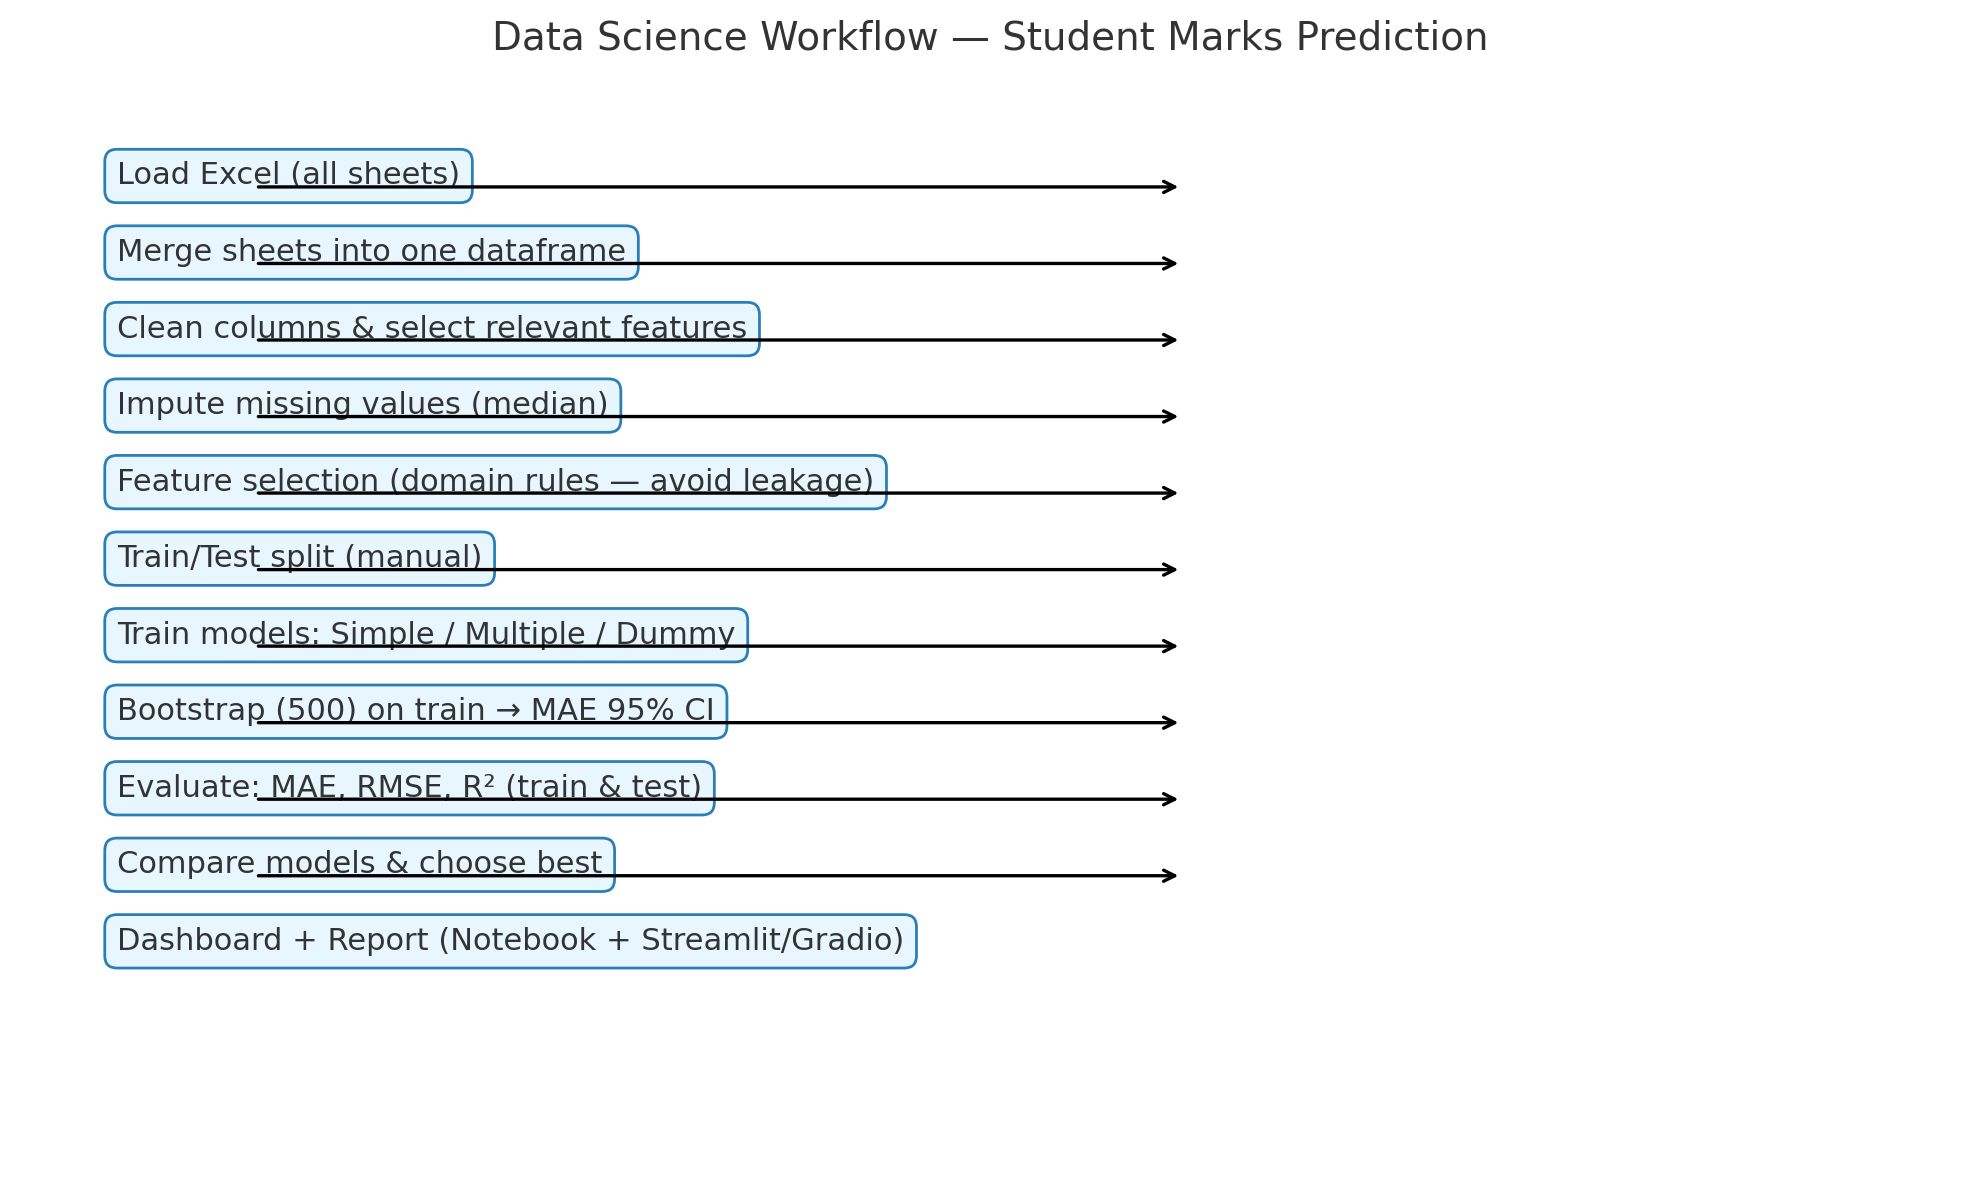